In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_predict

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score,average_precision_score, confusion_matrix
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.utils import shuffle
from catboost import CatBoostClassifier, cv, Pool
from sklearn.feature_selection import RFE

C:\Users\rk\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## 1. Знакомство с данными

In [2]:
try:
    df_contract = pd.read_csv('D:/Files/final_provider/contract.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
try:
    df_internet = pd.read_csv('D:/Files/final_provider/internet.csv')
except:
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [4]:
try:
    df_personal = pd.read_csv('D:/Files/final_provider/personal.csv')
except:
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
try:
    df_phone = pd.read_csv('D:/Files/final_provider/phone.csv')
except:
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Вывод
Можно заметить, кол-во сток в предоставленных таблицах отличается. Предположим, что не у всех клиентов подключены все услуги. Выясним точнее, когда объединим таблицы.

### 1.1 Описание признаков

In [6]:
df_contract.BeginDate.value_counts()

2014-02-01    366
2019-11-01    237
2019-10-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

#### df_contract (информация о договоре):
 - customerID - код клиента;
 - BeginDate - начало действия контракта;
 - EndDate - окончание действия контракта;
 - Type - порядок оплаты(раз в месяц,раз в год, раз в два года);
 - PaperlessBilling - безналичная расчет;
 - PaymentMethod - способ оплаты;
 - MonthlyCharges - размер ежемесячного платежа;
 - TotalCharges - всего оплачено.

#### df_personal(персональные данные клиента):
 - customerID - код клиента;
 - gender - пол;
 - SeniorCitizen - пожилой человек (пенсионер);
 - Partner - партнер (наверное, имеется в виду супруг/сожиетль);
 - Dependents - иждивенцы.

#### df_internet(информация об интернет-услугах):
 - customerID - код клиента;
 - InternetService - тип подключения;
 - OnlineSecurity - онлайн безопасность;
 - OnlineBackup - облачное хранилище файлов для резервного копирования данных;
 - DeviceProtection - антивирус;
 - TechSupport - выделенная линия технической поддержки;
 - StreamingTV - стриминговое телевидение;
 - StreamingMovies - каталог фильмов.

#### df_phone (информация об услугах телефонии):
 - customerID - код клиента;
 - MultipleLines - подключение к нескольким линиям.

### 1.2 Проверка наличия пропущенных значений

In [7]:
df_contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [8]:
df_internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [9]:
df_personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [10]:
df_phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

### Вывод
Пропусков в данных не обнаружено. Но в df_contract['TotalCharges'] были замечены пустые строки.

### 1.3 Изменение типов данных и добавление новых признаков


#### Добавим новый столбец, где обозначим ушел клиент или остался.
1 - ушел,
0 - остался.

In [11]:
df_contract['Status'] = df_contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Status
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### Заменим "No" в столбце "EndDate" на актуальную дату для подсчета периода действия контракта.

In [12]:
df_contract.loc[df_contract['EndDate']=='No','EndDate']='2020-02-01'
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Status
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### Изменим тип данных стобцов 'BeginDate' и 'EndDate' на datetime

In [13]:
df_contract['BeginDate']= pd.to_datetime(df_contract['BeginDate'], errors='ignore')
df_contract['EndDate']= pd.to_datetime(df_contract.query('EndDate != "No"')['EndDate'], errors='ignore')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Status            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


#### Изменим тип данных стобца 'TotalCharges' на float

In [14]:
def fill_empty_string(row):
    if row.strip():
        return row
    else:
        return 0

In [15]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].apply(fill_empty_string)

In [16]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')

In [17]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Status            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


#### Вычислим период действия контракта

In [18]:
df_contract['Period'] = df_contract['EndDate'] - df_contract['BeginDate']

In [19]:
df_contract['Period'] = pd.to_numeric(df_contract['Period'].dt.days)

In [20]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Status,Period
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


### 1.4 Распределение параметров

Посмотрим, распределение новых клиентов по годам.

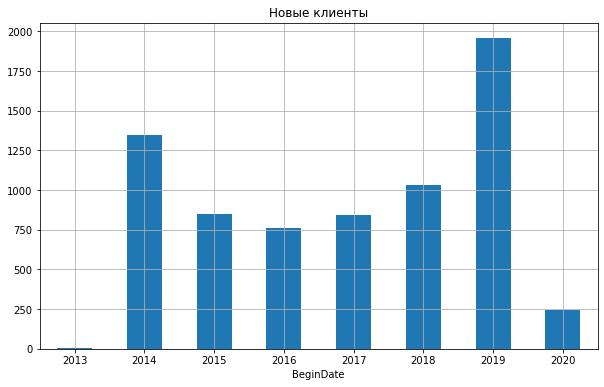

In [21]:
df_contract.groupby(df_contract['BeginDate'].dt.year)['MonthlyCharges'].count().plot(kind='bar',grid=True, title='Новые клиенты', rot=0, figsize=(10,6))

#### Вывод
Больше всего новых клиентов пришло в 2019-ом году. Возможно, что-то изменилось в тарифах.

#### Распределения:
 - платежей за месяц;
 - платежей за весь период;
 - периода действия контракта.

Text(0.5, 1.0, 'Период действия контракта ')

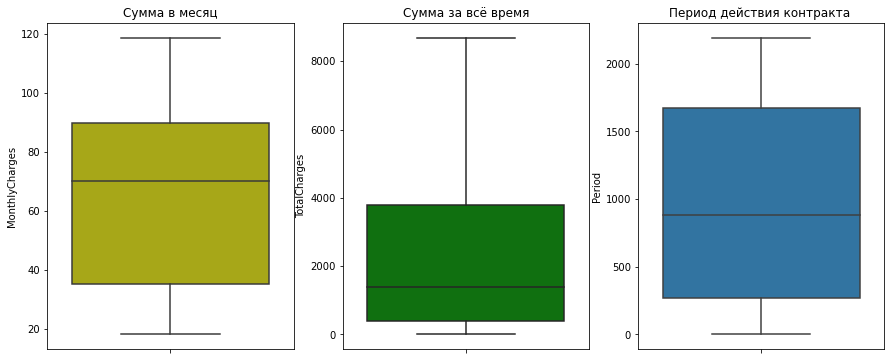

In [22]:
fig, axes = plt.subplots(ncols=3,figsize=(15,6))
sns.boxplot(df_contract['MonthlyCharges'], ax = axes[0], orient='v', color='y')
sns.boxplot(df_contract['TotalCharges'], ax = axes[1], orient='v', color='g')
sns.boxplot(df_contract['Period'], ax = axes[2], orient='v')

axes[0].set_title('Сумма в месяц')
axes[1].set_title('Сумма за всё время')
axes[2].set_title('Период действия контракта ')


#### Распределение по порядку оплаты

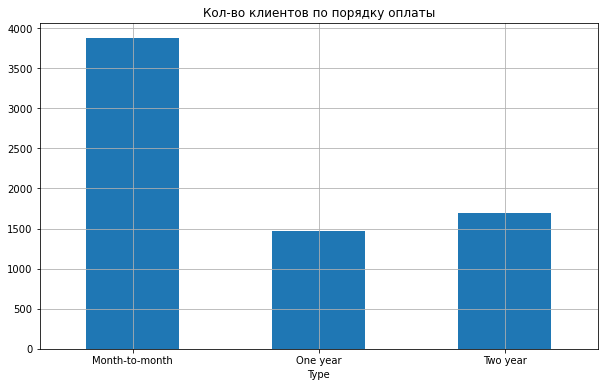

In [23]:
df_contract.groupby('Type')['Type'].count().plot(kind='bar',grid=True, title='Кол-во клиентов по порядку оплаты', rot=0, figsize=(10,6))

#### Вывод
Большинство клинетов предпочитают помесячную оплату.

#### Распределение по способу оплаты

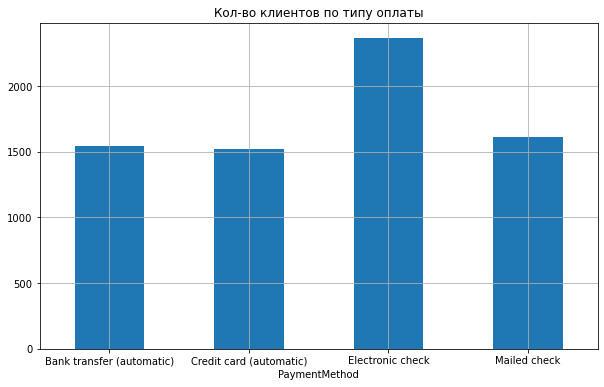

In [24]:
df_contract.groupby('PaymentMethod')['PaymentMethod'].count().plot(kind='bar',grid=True, title='Кол-во клиентов по типу оплаты', rot=0, figsize=(10,6))

#### Распределение по интернет-услугам

Text(0.5, 1.0, 'Каталог фильмов')

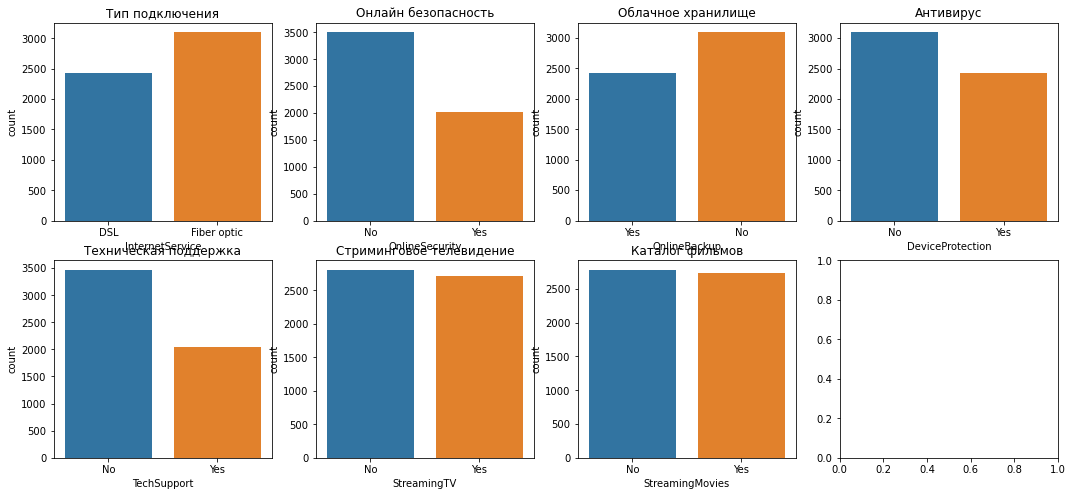

In [25]:
fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(18,8))

sns.countplot(x='InternetService', data=df_internet, ax=axes[0,0])
sns.countplot(x='OnlineSecurity', data=df_internet, ax=axes[0,1])
sns.countplot(x='OnlineBackup', data=df_internet, ax=axes[0,2])
sns.countplot(x='DeviceProtection', data=df_internet, ax=axes[0,3])
sns.countplot(x='TechSupport', data=df_internet, ax=axes[1,0])
sns.countplot(x='StreamingTV', data=df_internet, ax=axes[1,1])
sns.countplot(x='StreamingMovies', data=df_internet, ax=axes[1,2])

axes[0,0].set_title('Тип подключения')
axes[0,1].set_title('Онлайн безопасность')
axes[0,2].set_title('Облачное хранилище')
axes[0,3].set_title('Антивирус')
axes[1,0].set_title('Техническая поддержка')
axes[1,1].set_title('Стриминговое телевидение')
axes[1,2].set_title('Каталог фильмов')

#### Вывод
Интересно, что большинство клиентов пренебрегают антивирусом, техподдержкой и онлайн-безопасностью.

#### Распределение по персональным данным

Text(0.5, 1.0, 'Наличие иждивенцев')

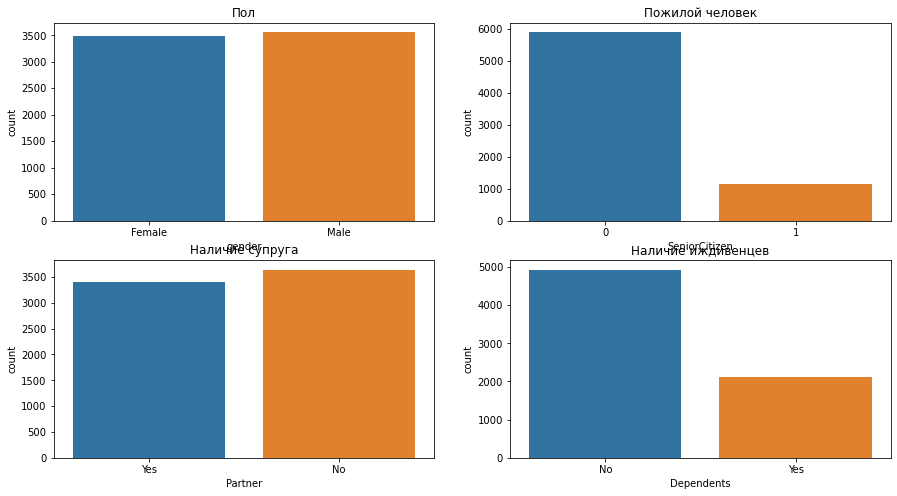

In [26]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(15,8))

sns.countplot(x='gender', data=df_personal, ax=axes[0,0])
sns.countplot(x='SeniorCitizen', data=df_personal, ax=axes[0,1])
sns.countplot(x='Partner', data=df_personal, ax=axes[1,0])
sns.countplot(x='Dependents', data=df_personal, ax=axes[1,1])

axes[0,0].set_title('Пол')
axes[0,1].set_title('Пожилой человек')
axes[1,0].set_title('Наличие супруга')
axes[1,1].set_title('Наличие иждивенцев')

#### Вывод
Среди клиентов подавляющее большинство людей не относящихся к пожилым.

#### Подключение к нескольким линиям

Text(0.5, 1.0, 'Подключение к нескольким линиям')

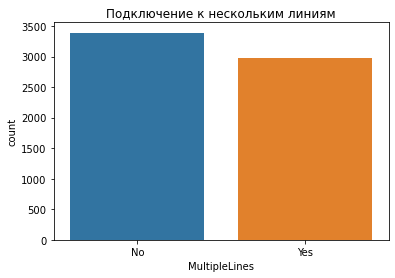

In [27]:
ax = sns.countplot(x='MultipleLines', data=df_phone)
ax.set_title('Подключение к нескольким линиям')

## 2. Подготовка данных для модели

#### Объединение таблиц

In [28]:
df_1 = df_personal.merge(df_internet, how='outer')
df_2 = df_1.merge(df_contract, how='outer')
df_all = df_2.merge(df_phone, how='outer')

In [29]:
df_all.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Status,Period,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,DSL,No,Yes,No,No,...,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,NaN
1,5575-GNVDE,Male,0,No,No,DSL,Yes,No,Yes,No,...,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,No
2,3668-QPYBK,Male,0,No,No,DSL,Yes,Yes,No,No,...,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,No
3,7795-CFOCW,Male,0,No,No,DSL,Yes,No,Yes,Yes,...,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,NaN
4,9237-HQITU,Female,0,No,No,Fiber optic,No,No,No,No,...,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,No


#### Заполнение появившихся пропущенных значений


In [30]:
# заполним пропущенные значения строкой 'No'
df_all = df_all.fillna('No')
df_all.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Status              0
Period              0
MultipleLines       0
dtype: int64

#### Удаление столбцов
Удалим 'customerID', 'BeginDate', 'EndDate'

In [31]:
df_all = df_all.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)


In [32]:
df_all.columns.to_list()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Status',
 'Period',
 'MultipleLines']

### 2.1 Кодирование категориальных переменных
Для регрессии применим метод 'One-Hot Encoding'. Для "деревянных" моделей применим метод 'Ordinal Encoding'.

In [33]:
# One-Hot Encoding
df_reg = pd.get_dummies(df_all, drop_first=True)
df_reg.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Status,Period,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Yes
0,0,29.85,29.85,0,31,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,56.95,1889.50,0,1036,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,53.85,108.15,1,61,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,42.30,1840.75,0,1371,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,70.70,151.65,1,61,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0


In [34]:
# Ordinal Encoding
df_wood = df_all.copy()

category_col = ['gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MultipleLines']
encoder = OrdinalEncoder()
encoder.fit(df_wood[category_col]) 
df_wood[category_col] = encoder.transform(df_wood[category_col]).astype('int')
df_wood.head()

,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Status,Period,MultipleLines
0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0,31,0
1,1,0,0,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0,1036,0
2,1,0,0,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1,61,0
3,1,0,0,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0,1371,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,61,0


### 2.2 Разделение данных на тренировочную и тестовую выборки

In [35]:
# баланс классов
df_all['Status'].value_counts() / df_all['Status'].shape[0]

0    0.73463
1    0.26537
Name: Status, dtype: float64

In [36]:
#разделим данные для регресионных моделей  на тренировочную и тестовую выборки без учета дисбаланса
df_reg_features = df_reg.drop('Status', axis=1)
df_reg_target = df_reg['Status']

reg_features_train, reg_features_test, reg_target_train, reg_target_test = train_test_split(df_reg_features, df_reg_target, test_size=0.25, random_state=1)

In [37]:
#разделим данные для 'деревянных' моделей  на тренировочную и тестовую выборки без учета дисбаланса
df_wood_features = df_wood.drop('Status', axis=1)
df_wood_target = df_wood['Status']

wood_features_train, wood_features_test, wood_target_train, wood_target_test = train_test_split(df_wood_features, df_wood_target, test_size=0.25, random_state=1)

In [38]:
# баланс классов регрессионных
reg_target_train.value_counts() / reg_target_train.shape[0]

0    0.728323
1    0.271677
Name: Status, dtype: float64

In [39]:
# баланс классов деревянных
wood_target_train.value_counts() / wood_target_train.shape[0]

0    0.728323
1    0.271677
Name: Status, dtype: float64

## 3. Обучение базовых моделей
Обучим модели без учета дисбаланса классов и без подбора гиперпараметров.

In [40]:
#функция для графиков roc и precision-recall
def graph(fpr,tpr,auc_roc):
    fig, ax = plt.subplots(figsize=(8,8))

    ax.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC-кривая')
    ax.grid(True)

    add_titlebox(ax=ax, text=f'AUC_ROC = {auc_roc.round(3)}',x=0.8,y=0.25)

    plt.show()

In [41]:
#функция для подписей на графиках
def add_titlebox(ax, text, x,y):
    ax.text(x, y, text, horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='green', alpha=0.6),
        fontsize=12.5)
    return ax

In [42]:
#функция для матрицы ошибок
def conf_matrix(target,predict):
    cm = pd.DataFrame(confusion_matrix(target,predict), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
    display(cm)

In [43]:
# функция обновления таблицы результатов
def res_data(df, auc_roc, accuracy, target, predict, name):
    tn, fp, fn, tp = confusion_matrix(target,predict).ravel()
    df = df.append(pd.Series(data={'auc_roc':round(auc_roc,3), 'accuracy': round(accuracy,3), 'TP': tp, 'FP':fp}, name=name), ignore_index=False)
    return df

In [44]:
# # функция подбора порога
# def find_threshold(model, x, y):
#     proba = cross_val_predict(model, x, y, cv=5, method='predict_proba',n_jobs=-1)
#     proba_one = proba[:, 1]
#     max_f1 = 0
#     best_threshold = 0
#     for threshold in tqdm(np.arange(0, 0.95, 0.02)):
#         predicted = proba_one > threshold
#         f1 = f1_score(y, predicted)
#         if f1 > max_f1:
#             max_f1 = f1
#             best_threshold = threshold
#     return max_f1, best_threshold

### 3.1 Логистическая регрессия

In [45]:
model_lr = LogisticRegression(random_state=1, max_iter=500)

In [46]:
# предсказание вероятностей
model_lr.fit(reg_features_train,reg_target_train)
probabilities_test = model_lr.predict_proba(reg_features_test)

In [47]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

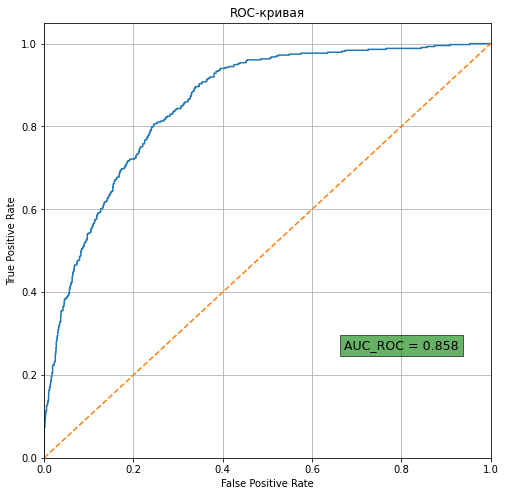

,predicted 0,predicted 1
actual 0,1186,141
actual 1,193,241


In [48]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(reg_target_test, probabilities_one_test)
auc_roc = roc_auc_score(reg_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(reg_target_test, predict_test)

In [49]:
acc = accuracy_score(reg_target_test, predict_test)
f'Accuracy логистической регрессии равно {acc:0.3f}'

'Accuracy логистической регрессии равно 0.810'

In [50]:
tn, fp, fn, tp = confusion_matrix(reg_target_test, predict_test).ravel()
df_results = pd.DataFrame({'auc_roc':auc_roc, 'accuracy': acc, 'TP':tp, 'FP':fp}, index = ['Логистическая регрессия'])

### 3.2 Дерево решений

In [63]:
model_wood = DecisionTreeClassifier(random_state=1, max_depth=5)

In [64]:
# предсказание вероятностей
model_wood.fit(wood_features_train,wood_target_train)
probabilities_test = model_wood.predict_proba(wood_features_test)

In [65]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

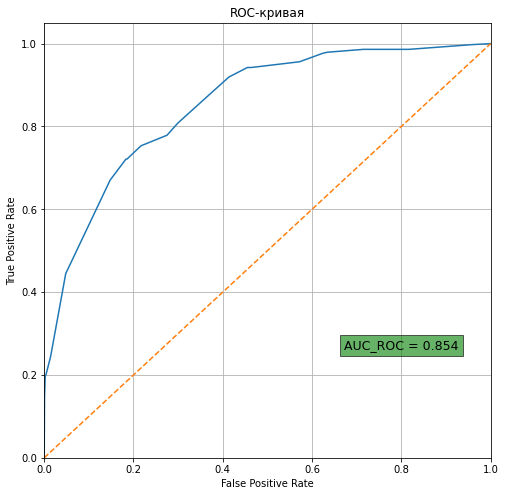

,predicted 0,predicted 1
actual 0,1263,64
actual 1,241,193


In [66]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [67]:
acc = accuracy_score(reg_target_test, predict_test)
f'Accuracy дерева решений равно {acc:0.3f}'

'Accuracy дерева решений равно 0.827'

In [68]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'Дерево решений')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0


### 3.2.1 Важность признаков для дерева решений

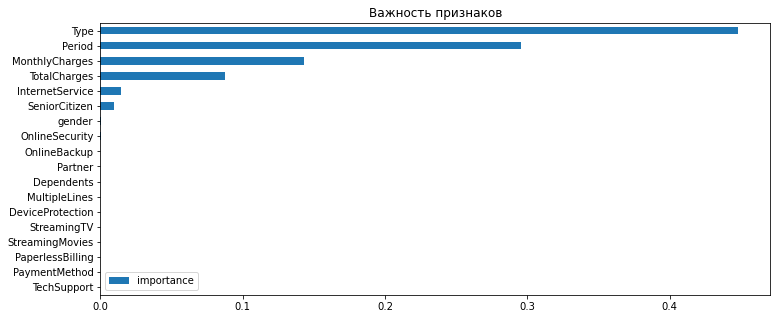

In [69]:
importances = model_wood.feature_importances_
df_importances = pd.DataFrame(index=wood_features_train.columns, columns=['importance'], data=importances)
df_importances = abs(df_importances)
df_importances.sort_values(by='importance').plot(kind='barh', title='Важность признаков', figsize=(12,5), mark_right=True)

#### Интересно, что для дерева решений наиболее важные признаки не совпадают с признаками для логистической регрессии.

In [70]:
features_wood = df_importances.sort_values(by='importance', ascending=False).index
features_wood = features_wood.to_list()

#### Посмотрим, как меняются метрики при изменении кол-ва признаков. Возьмем сначала самый важный и будем прибавлять по одному.

In [71]:
f= []
df_res = pd.DataFrame()
n = 1
for i in features_wood:
    f.append(i)
    model_wood.fit(wood_features_train[f],wood_target_train)
    probabilities_test = model_wood.predict_proba(wood_features_test[f])
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
    predicted = probabilities_one_test>0.5
    f1 = f1_score(wood_target_test, predicted)
    accuracy = accuracy_score(wood_target_test, predicted)
    if n==1:
        df_res = pd.DataFrame({'auc_roc':auc_roc, 'f1':f1, 'accuracy': accuracy}, index = [n])
    else:
        df_res = df_res.append(pd.Series(data={'auc_roc':auc_roc, 'f1':f1, 'accuracy': accuracy}, name=n), ignore_index=False)
    n=n+1
df_res

,auc_roc,f1,accuracy
1,0.757487,0.000000,0.753549
2,0.832220,0.311284,0.798978
3,0.852954,0.554745,0.826803
4,0.853021,0.554745,0.826803
5,0.854035,0.554745,0.826803
6,0.854490,0.558611,0.826803
7,0.853503,0.558611,0.826803
8,0.853690,0.558611,0.826803
9,0.853690,0.558611,0.826803
10,0.853690,0.558611,0.826803


#### После восьмого прирост метрики останавливается.

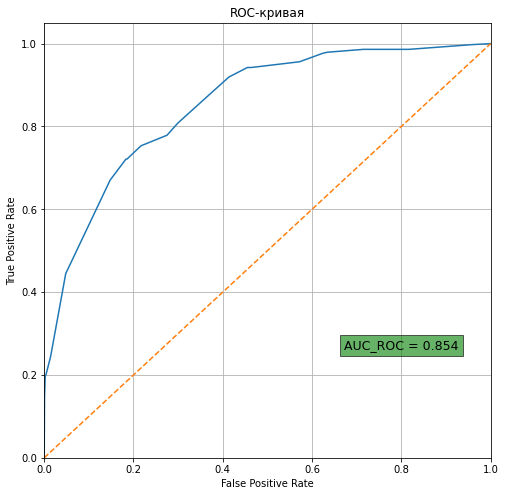

,predicted 0,predicted 1
actual 0,1263,64
actual 1,241,193


In [72]:
features_wood = features_wood[0:8]
# предсказание вероятностей
model_wood.fit(wood_features_train[features_wood],wood_target_train)
probabilities_test = model_wood.predict_proba(wood_features_test[features_wood])
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [73]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy дерева решений равно {acc:0.3f}'

'Accuracy дерева решений равно 0.827'

In [74]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'Дерево решений(f_i)')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0


### Вывод
Ничего не изменилось

### 3.3 Случайный лес

In [75]:
#случайный лес
model_forest = RandomForestClassifier(random_state=2)

In [76]:
# предсказание вероятностей
model_forest.fit(wood_features_train,wood_target_train)
probabilities_test = model_forest.predict_proba(wood_features_test)

In [77]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

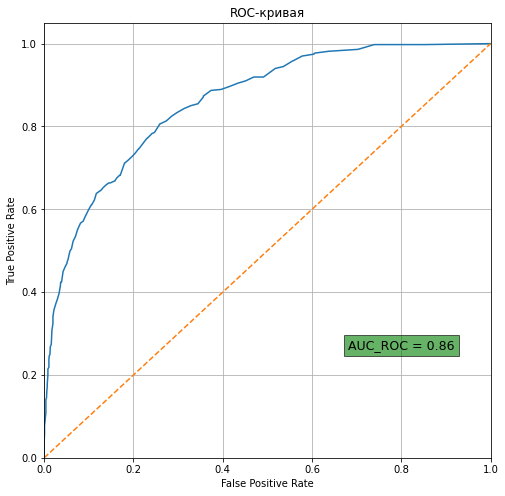

,predicted 0,predicted 1
actual 0,1219,108
actual 1,188,246


In [78]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [79]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy случайного леса равно {acc:0.3f}'

'Accuracy случайного леса равно 0.832'

In [80]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'Случайный лес')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0
Случайный лес,0.86000,0.832000,246.0,108.0


### 3.3.1 Важность признаков для случайного леса

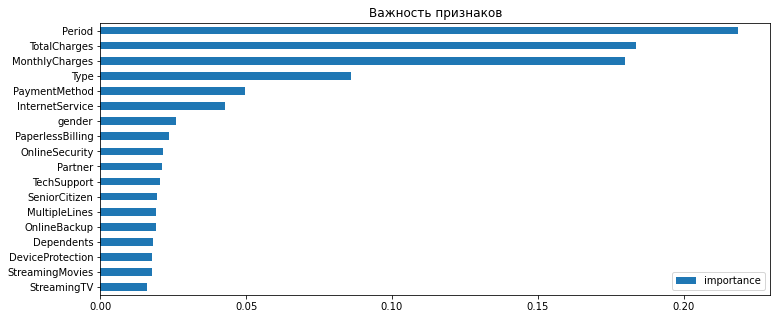

In [81]:
importances = model_forest.feature_importances_
df_importances = pd.DataFrame(index=wood_features_train.columns, columns=['importance'], data=importances)
df_importances = abs(df_importances)
df_importances.sort_values(by='importance').plot(kind='barh', title='Важность признаков', figsize=(12,5), mark_right=True)


In [82]:
features_forest = df_importances.sort_values(by='importance', ascending=False).index
features_forest = features_forest.to_list()

#### Посмотрим, как меняются метрики при изменении кол-ва признаков. Возьмем сначала самый важный и будем прибавлять по одному.

In [83]:
f= []
model_forest = RandomForestClassifier(random_state=2)
df_res = pd.DataFrame()
n = 1
for i in features_forest:
    f.append(i)
    model_forest.fit(wood_features_train[f],wood_target_train)
    probabilities_test = model_forest.predict_proba(wood_features_test[f])
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
    predicted = probabilities_one_test>0.5
    f1 = f1_score(wood_target_test, predicted)
    accuracy = accuracy_score(wood_target_test, predicted)
    if n==1:
        df_res = pd.DataFrame({'auc_roc':auc_roc, 'f1':f1, 'accuracy': accuracy}, index = [n])
    else:
        df_res = df_res.append(pd.Series(data={'auc_roc':auc_roc, 'f1':f1, 'accuracy': accuracy}, name=n), ignore_index=False)
    n=n+1
df_res

,auc_roc,f1,accuracy
1,0.928704,0.732847,0.896082
2,0.873695,0.659259,0.843271
3,0.854962,0.627907,0.836457
4,0.857062,0.635678,0.835321
5,0.857995,0.641604,0.837592
6,0.860687,0.642038,0.840432
7,0.858360,0.629862,0.832482
8,0.858102,0.632500,0.833049
9,0.859034,0.642317,0.838728
10,0.858778,0.616967,0.830778


#### Интересно, всего один признак дает отличное значение метрики. Но методы библиотеки не пропускаю одномерный массив, поэтому схитрим и добавим столбец с одинаковыми значениями для всех наблюдений.

<ipython-input-84-59a038a43904>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_features_train_fi['TotalCharges'] = forest_features_train_fi['TotalCharges']*0
<ipython-input-84-59a038a43904>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_feat_test_fi['TotalCharges'] = forest_feat_test_fi['TotalCharges']*0


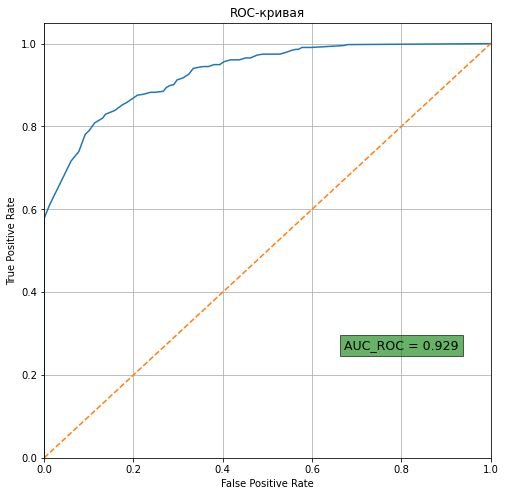

,predicted 0,predicted 1
actual 0,1327,0
actual 1,183,251


In [84]:
forest_features_train_fi = wood_features_train[['Period', 'TotalCharges']]
forest_features_train_fi['TotalCharges'] = forest_features_train_fi['TotalCharges']*0

forest_feat_test_fi = wood_features_test[['Period', 'TotalCharges']]
forest_feat_test_fi['TotalCharges'] = forest_feat_test_fi['TotalCharges']*0
# предсказание вероятностей
model_forest.fit(forest_features_train_fi,wood_target_train)
probabilities_test = model_forest.predict_proba(forest_feat_test_fi)
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [85]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy случайного леса равно {acc:0.3f}'

'Accuracy случайного леса равно 0.896'

In [86]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'Случайный лес(f_i)')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0
Случайный лес,0.86000,0.832000,246.0,108.0
Случайный лес(f_i),0.92900,0.896000,251.0,0.0


### Вывод
Метрика значительно выросла. И FP упало до нуля.

### 3.4 CatBoost

In [87]:
category_col = ['gender','SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MultipleLines']

In [88]:
%%time
model_cat = CatBoostClassifier(eval_metric='AUC',iterations=2000, verbose=False)

Wall time: 0 ns


In [89]:
# предсказание вероятностей`
model_cat.fit(wood_features_train,wood_target_train)
probabilities_test = model_cat.predict_proba(wood_features_test)

In [90]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

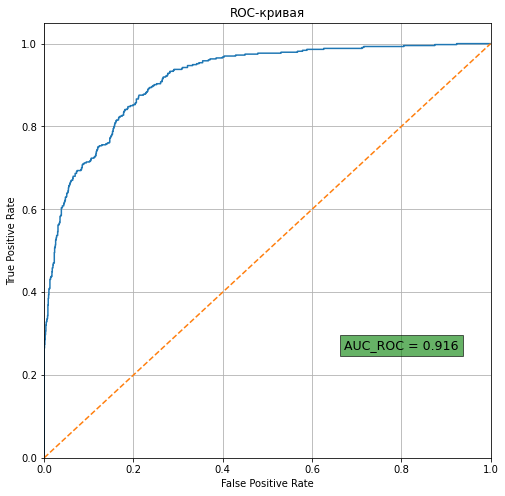

,predicted 0,predicted 1
actual 0,1255,72
actual 1,154,280


In [91]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [92]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy CatBoost равно {accuracy_score(wood_target_test, predict_test):0.3f}'

'Accuracy CatBoost равно 0.872'

In [93]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'CatBoost')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0
Случайный лес,0.86000,0.832000,246.0,108.0
Случайный лес(f_i),0.92900,0.896000,251.0,0.0
CatBoost,0.91600,0.872000,280.0,72.0


### 3.4.1 Важность признаков для CatBoost

In [94]:
importances = model_cat.get_feature_importance()

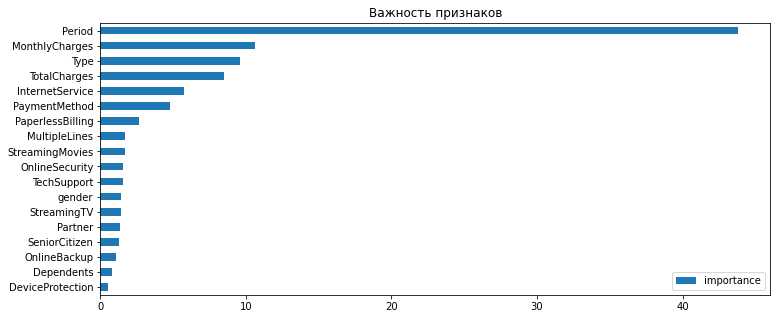

In [95]:
df_importances = pd.DataFrame(index=wood_features_train.columns, columns=['importance'], data=importances)
df_importances = abs(df_importances)
df_importances.sort_values(by='importance').plot(kind='barh', title='Важность признаков', figsize=(12,5), mark_right=True)

In [96]:
features_cat = df_importances.sort_values(by='importance', ascending=False).index
features_cat = features_cat.to_list()

In [97]:
f= []
df_res = pd.DataFrame()
n = 1

for i in features_cat:
    f.append(i)
    model_cat.fit(wood_features_train[f],wood_target_train)
    probabilities_test = model_cat.predict_proba(wood_features_test[f])
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
    predicted = probabilities_one_test>0.5
    f1 = f1_score(wood_target_test, predicted)
    accuracy = accuracy_score(wood_target_test, predicted)
    if n==1:
        df_res = pd.DataFrame({'auc_roc':auc_roc, 'f1':f1, 'accuracy': accuracy}, index = [n])
    else:
        df_res = df_res.append(pd.Series(data={'auc_roc':auc_roc, 'f1':f1, 'accuracy': accuracy}, name=n), ignore_index=False)
    n=n+1
df_res

,auc_roc,f1,accuracy
1,0.921448,0.682853,0.881317
2,0.922270,0.722372,0.883021
3,0.928282,0.720000,0.880750
4,0.920937,0.688172,0.868257
5,0.922996,0.704787,0.873935
6,0.923554,0.718016,0.877342
7,0.921666,0.717815,0.876775
8,0.923399,0.713178,0.873935
9,0.921416,0.719794,0.876207
10,0.921617,0.722151,0.876775


#### Можно заметить, что AUC-ROC принимает максимальное значение на трех признаках.

(1761,)


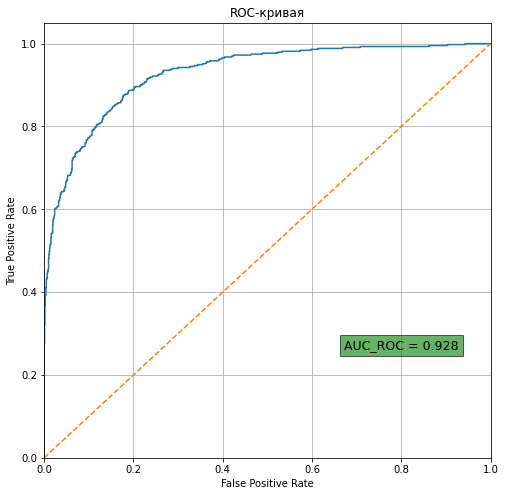

,predicted 0,predicted 1
actual 0,1281,46
actual 1,164,270


In [98]:
features_cat = features_cat[0:3]
# предсказание вероятностей
model_cat.fit(wood_features_train[features_cat],wood_target_train)
probabilities_test = model_cat.predict_proba(wood_features_test[features_cat])
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
print(probabilities_one_test.shape)
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [99]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy CatBoost равно {accuracy_score(wood_target_test, predict_test):0.3f}'

'Accuracy CatBoost равно 0.881'

In [100]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'CatBoost(f_i)')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0
Случайный лес,0.86000,0.832000,246.0,108.0
Случайный лес(f_i),0.92900,0.896000,251.0,0.0
CatBoost,0.91600,0.872000,280.0,72.0
CatBoost(f_i),0.92800,0.881000,270.0,46.0


### Вывод
AUC_ROC незначительно выросла до 0.928, TP снизилось на 10 единиц, но зато FP упало на 26 единиц.

## 4. Борьба с дисбалансом (увеличение выборки)

Увеличим кол-во объектов меньшего класса в обучающей выборке путем копирования и перемешивания.

In [101]:
# функция для увеличения выборки
def upsampling(features_train,target_train,repeat):
    features_zeros = features_train[target_train==0]
    features_ones = features_train[target_train==1]
    target_zeros = target_train[target_train==0]
    target_ones = target_train[target_train==1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    shuffle(features_upsampled)
    shuffle(target_upsampled)
    return features_upsampled, target_upsampled

In [102]:
# увеличение выборки для регрессионных моделей
reg_features_train_up, reg_target_train_up = upsampling(reg_features_train, reg_target_train, 3)
# проверим как изменился дисбаланс
reg_target_train_up.value_counts()/reg_target_train_up.shape[0]

1    0.528091
0    0.471909
Name: Status, dtype: float64

In [103]:
# увеличение выборки для решающего дерева и случайного леса
wood_features_train_up, wood_target_train_up = upsampling(wood_features_train, wood_target_train, 3)
# проверим как изменился дисбаланс
wood_target_train_up.value_counts()/wood_target_train_up.shape[0]

1    0.528091
0    0.471909
Name: Status, dtype: float64

### 4.1 Логистическая регрессия

In [104]:
model_lr = LogisticRegression(random_state=1, max_iter=500)

In [105]:
# предсказание вероятностей
model_lr.fit(reg_features_train_up,reg_target_train_up)
probabilities_test = model_lr.predict_proba(reg_features_test)
probabilities_test.shape

(1761, 2)

In [106]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

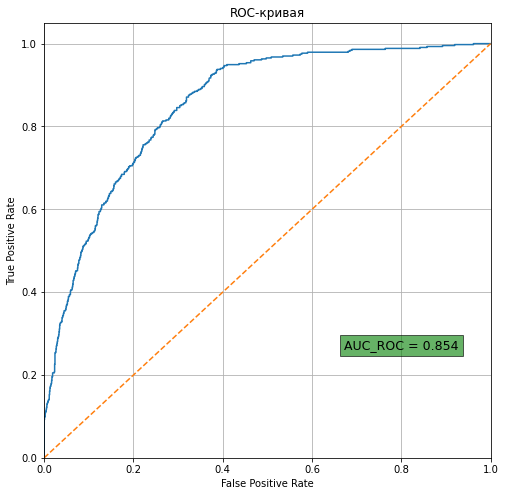

,predicted 0,predicted 1
actual 0,964,363
actual 1,80,354


In [107]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(reg_target_test, probabilities_one_test)
auc_roc = roc_auc_score(reg_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(reg_target_test, predict_test)

In [108]:
acc = accuracy_score(reg_target_test, predict_test)
f'Accuracy логистической регрессии равно {acc:0.3f}'

'Accuracy логистической регрессии равно 0.748'

In [109]:
df_results = res_data(df_results, auc_roc, acc, reg_target_test, predict_test, 'Логистическая регрессия(up)')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0
Случайный лес,0.86000,0.832000,246.0,108.0
Случайный лес(f_i),0.92900,0.896000,251.0,0.0
CatBoost,0.91600,0.872000,280.0,72.0
CatBoost(f_i),0.92800,0.881000,270.0,46.0
Логистическая регрессия(up),0.85400,0.748000,354.0,363.0


### Вывод
Значение AUC-ROC практически не изменилось. Значение TP зачительно увеличилось (на 113 единиц), но также увеличилось и значение FP.

### 4.2 Дерево решений

In [110]:
model_wood = DecisionTreeClassifier(random_state=1, max_depth=5)

In [111]:
# предсказание вероятностей
model_wood.fit(wood_features_train_up,reg_target_train_up)
probabilities_test = model_wood.predict_proba(wood_features_test)


In [112]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

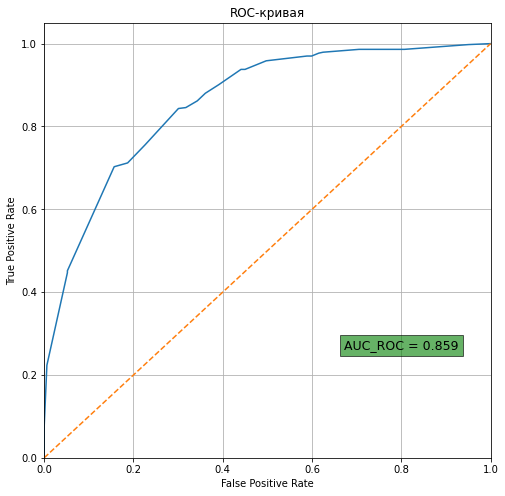

,predicted 0,predicted 1
actual 0,928,399
actual 1,68,366


In [113]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [114]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy дерева решений равно {accuracy_score(wood_target_test, predict_test):0.3f}'

'Accuracy дерева решений равно 0.735'

In [115]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'Дерево решений(up)')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0
Случайный лес,0.86000,0.832000,246.0,108.0
Случайный лес(f_i),0.92900,0.896000,251.0,0.0
CatBoost,0.91600,0.872000,280.0,72.0
CatBoost(f_i),0.92800,0.881000,270.0,46.0
Логистическая регрессия(up),0.85400,0.748000,354.0,363.0
Дерево решений(up),0.85900,0.735000,366.0,399.0


### Вывод
Значение AUC-ROC практически не изменилось. Значение TP зачительно увеличилось (на 173 единиц), но также увеличилось и значение FP.

### 4.3 Случайный лес

In [116]:
#случайный лес
model_forest = RandomForestClassifier(random_state=2)

In [117]:
# предсказание вероятностей
model_forest.fit(wood_features_train_up,reg_target_train_up)
probabilities_test = model_forest.predict_proba(wood_features_test)

In [118]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

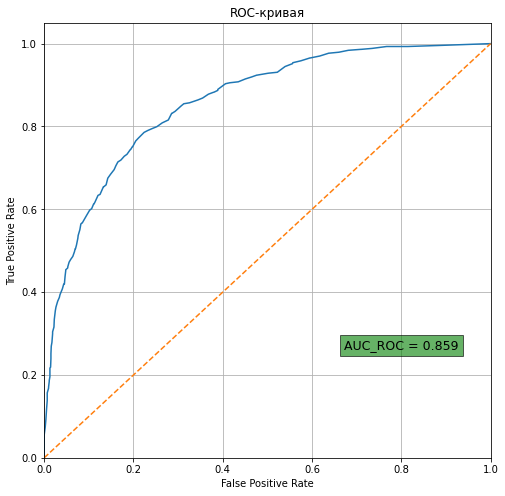

,predicted 0,predicted 1
actual 0,1150,177
actual 1,150,284


In [119]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [120]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy случайного леса равно {accuracy_score(wood_target_test, predict_test):0.3f}'

'Accuracy случайного леса равно 0.814'

In [121]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'Случайный лес(up)')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0
Случайный лес,0.86000,0.832000,246.0,108.0
Случайный лес(f_i),0.92900,0.896000,251.0,0.0
CatBoost,0.91600,0.872000,280.0,72.0
CatBoost(f_i),0.92800,0.881000,270.0,46.0
Логистическая регрессия(up),0.85400,0.748000,354.0,363.0
Дерево решений(up),0.85900,0.735000,366.0,399.0


### Вывод
Значение AUC-ROC практически не изменилось. Значение TP увеличилось (на 38 единиц), но также увеличилось и значение FP.

### 3.4.1 Случайный лес с учетом важности признаков.
Вычислим значение AUC-ROC на увеличенной выборке с признаками определенными в пункте 3.

<ipython-input-122-566072951bef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_features_train_up['TotalCharges'] = forest_features_train_up['TotalCharges']*0
<ipython-input-122-566072951bef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_feat_test['TotalCharges'] = forest_feat_test['TotalCharges']*0


(1761,)


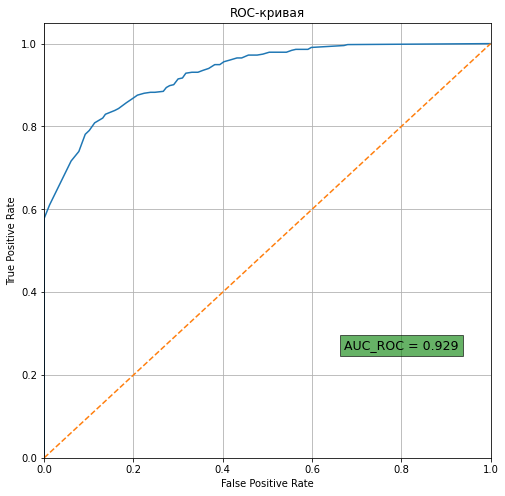

,predicted 0,predicted 1
actual 0,1145,182
actual 1,74,360


In [122]:
forest_features_train_up = wood_features_train_up[['Period', 'TotalCharges']]
forest_features_train_up['TotalCharges'] = forest_features_train_up['TotalCharges']*0

forest_feat_test = wood_features_test[['Period', 'TotalCharges']]
forest_feat_test['TotalCharges'] = forest_feat_test['TotalCharges']*0
# предсказание вероятностей
model_forest.fit(forest_features_train_up,wood_target_train_up)
probabilities_test = model_forest.predict_proba(forest_feat_test)
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
print(probabilities_one_test.shape)
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [123]:
f'Accuracy случайного леса равно {accuracy_score(wood_target_test, predict_test):0.3f}'

'Accuracy случайного леса равно 0.855'

In [124]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'Случайный лес(f_i, up)')
df_results

,auc_roc,accuracy,TP,FP
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0
Дерево решений,0.85400,0.827000,193.0,64.0
Дерево решений(f_i),0.85400,0.827000,193.0,64.0
Случайный лес,0.86000,0.832000,246.0,108.0
Случайный лес(f_i),0.92900,0.896000,251.0,0.0
CatBoost,0.91600,0.872000,280.0,72.0
CatBoost(f_i),0.92800,0.881000,270.0,46.0
Логистическая регрессия(up),0.85400,0.748000,354.0,363.0
Дерево решений(up),0.85900,0.735000,366.0,399.0


### Вывод
Значение AUC-ROC практически не изменилось. Значение TP увеличилось (на 90 единиц), но также увеличилось и значение FP.

### 4.4 CatBoost

In [125]:
%%time
model_cat = CatBoostClassifier(eval_metric='AUC',iterations=2000, verbose=False,)

Wall time: 0 ns


In [126]:
# предсказание вероятностей`
model_cat.fit(wood_features_train_up,wood_target_train_up)
probabilities_test = model_cat.predict_proba(wood_features_test)

In [127]:
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5

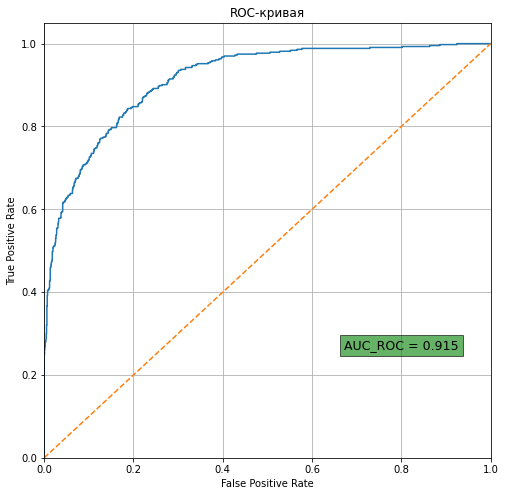

,predicted 0,predicted 1
actual 0,1100,227
actual 1,77,357


In [128]:
#roc-кривая
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [129]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy CatBoost равно {accuracy_score(wood_target_test, predict_test):0.3f}'

'Accuracy CatBoost равно 0.827'

In [130]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'CatBoost(up)')
df_results.sort_values(by='auc_roc', ascending=False)

,auc_roc,accuracy,TP,FP
Случайный лес(f_i),0.92900,0.896000,251.0,0.0
"Случайный лес(f_i, up)",0.92900,0.814000,360.0,182.0
CatBoost(f_i),0.92800,0.881000,270.0,46.0
CatBoost,0.91600,0.872000,280.0,72.0
CatBoost(up),0.91500,0.827000,357.0,227.0
Случайный лес,0.86000,0.832000,246.0,108.0
Дерево решений(up),0.85900,0.735000,366.0,399.0
Случайный лес(up),0.85900,0.814000,284.0,177.0
Логистическая регрессия,0.85755,0.810335,241.0,141.0
Логистическая регрессия(f_i),0.85600,0.810000,243.0,143.0


### Вывод
Значение AUC-ROC практически не изменилось. Значение TP увеличилось (на 77 единиц), но также увеличилось и значение FP.

### 4.4.1 CatBoost с учетом важности призников

(1761,)


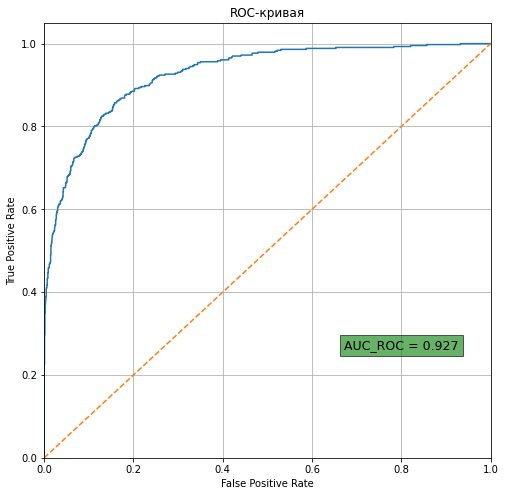

,predicted 0,predicted 1
actual 0,1110,217
actual 1,60,374


In [131]:

# предсказание вероятностей
model_cat.fit(wood_features_train_up[features_cat],wood_target_train_up)
probabilities_test = model_cat.predict_proba(wood_features_test[features_cat])
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
print(probabilities_one_test.shape)
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [132]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy CatBoost равно {accuracy_score(wood_target_test, predict_test):0.3f}'

'Accuracy CatBoost равно 0.843'

In [133]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'CatBoost(f_i, up)')

### Вывод
Значение AUC-ROC практически не изменилось. Значение TP увеличилось (на 77 единиц), но также увеличилось и значение FP.

### 4.5 Результаты

In [134]:
df_results[['auc_roc', 'accuracy']] = df_results[['auc_roc', 'accuracy']].round(3)
df_results[['TP', 'FP']] = df_results[['TP', 'FP']].astype('int')
df_results.sort_values(by='auc_roc', ascending=False)

,auc_roc,accuracy,TP,FP
Случайный лес(f_i),0.929,0.896,251,0
"Случайный лес(f_i, up)",0.929,0.814,360,182
CatBoost(f_i),0.928,0.881,270,46
"CatBoost(f_i, up)",0.927,0.843,374,217
CatBoost,0.916,0.872,280,72
CatBoost(up),0.915,0.827,357,227
Случайный лес,0.860,0.832,246,108
Дерево решений(up),0.859,0.735,366,399
Случайный лес(up),0.859,0.814,284,177
Логистическая регрессия,0.858,0.810,241,141


### Вывод
Лучшие результаты показали следующие модели:
 - Случайный лес при отборе признаков;
 - Случайный лес при отборе признаков и увеличенной выборке;
 - CatBoost при отборе признаков.

## 5. Подбор гиперпараметров

#### Для трех лучших моделей подберем гиперпараметры

### 5.1 Подбор гиперпараметров для случайного леса

Парметры для подбора:
 - n_estimators — число «деревьев» в «случайном лесу».
 - max_depth — максимальная глубина деревьев.
 - min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
 - min_samples_leaf — минимальное число объектов в листьях.

### Вывод
Подбор гиперпараметров для случайного леса не дал результатов, видимо, из-за того, что у нас остался только один признак.

In [135]:
# # подготовка для RandomizedSearchCV на выборке
# n_estimators = [int(x) for x in np.linspace(start = 500, stop = 800, num = 25)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]
# max_depth = [int(x) for x in np.linspace(start = 70, stop = 300, num = 30)]
# min_samples_split = [int(x) for x in np.linspace(start = 5, stop = 15, num = 10)]
# param_dist = {'n_estimators': n_estimators,
#                'min_samples_split': min_samples_split,
#                'max_depth': max_depth,
#              'min_samples_leaf':min_samples_leaf}

In [136]:
# # подбор гиперпараметров
# rs = RandomizedSearchCV(model_forest, 
#                         param_dist, 
#                         n_iter = 100, 
#                         cv = 4, 
#                         verbose = 1, 
#                         n_jobs=-1, 
#                         random_state=0, scoring='roc_auc')
# rs.fit(forest_features_train_fi,wood_target_train)

In [137]:
# # результаты подбора сформируем в датафрейм
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
#             'mean_fit_time', 
#             'std_fit_time', 
#             'mean_score_time',
#             'std_score_time', 
#             'params', 
#             'split0_test_score', 
#             'split1_test_score', 
#             'split2_test_score', 
#             'std_test_score'],
#             axis=1)
# rs_df.head()

In [138]:
# # визуализируем результаты подбора гиперпараметров
# sns.set(style="whitegrid", color_codes=True, font_scale = 1.5)
# fig, axs = plt.subplots(ncols=2,nrows=2)
# fig.set_size_inches(50,40)
# sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
# axs[0,0].set_ylim([0,1])
# axs[0,0].set_title(label = 'n_estimators')

# sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[0,1], color='lightpink')
# axs[0,1].set_ylim([0,1])
# axs[0,1].set_title(label = 'max_depth')

# sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
# axs[1,0].set_ylim([0,1])
# axs[1,0].set_title(label = 'min_samples_split')

# sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightgreen')
# axs[1,1].set_ylim([0,1])
# axs[1,1].set_title(label = 'min_samples_leaf')

# plt.show()

In [139]:
# #более точный подбор гиперпараметров при помощи GridSearchCV
# n_estimators = [699,700,701]
# max_depth = [170,171,172]
# min_samples_split  = [1,2,3]
# min_samples_leaf=[1,2]
# param_grid = {'n_estimators': n_estimators,
#                'min_samples_split': min_samples_split,
#                'max_depth': max_depth,
#              'min_samples_leaf':min_samples_leaf}

In [140]:
# gs = GridSearchCV(model_forest, param_grid, cv = 4, verbose = 1, n_jobs=-1,scoring='roc_auc')
# gs.fit(forest_features_train_fi,wood_target_train)
# model_forest_best = gs.best_estimator_
# gs.best_params_

In [141]:
# # model_forest_best = RandomForestClassifier(random_state=2, max_depth=172, min_samples_leaf = 1,min_samples_split=2,n_estimators=700)
# forest_feat_test = wood_features_test[['Period', 'TotalCharges']]
# forest_feat_test['TotalCharges'] = forest_feat_test['TotalCharges']*0
# # предсказание вероятностей
# model_forest_best.fit(forest_features_train_fi,wood_target_train)
# probabilities_test = model_forest_best.predict_proba(forest_feat_test)
# probabilities_one_test = probabilities_test[:, 1]
# predict_test = probabilities_one_test>0.5
# #roc-кривая
# fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
# auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
# graph(fpr,tpr,auc_roc)
# # матрица ошибок
# conf_matrix(wood_target_test, predict_test)

In [142]:
# acc = accuracy_score(wood_target_test, predict_test)
# f'Accuracy случайного леса равно {acc:0.3f}'

### 5.2 Подбор гиперпараметров для случайного леса на увеличенной выборке

Парметры для подбора:
 - n_estimators — число «деревьев» в «случайном лесу».
 - max_depth — максимальная глубина деревьев.
 - min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
 - min_samples_leaf — минимальное число объектов в листьях.

### Вывод
Аналогично предыдущему пункту, подбор гиперпараметров для случайного леса не дал результатов, видимо, из-за того, что у нас остался только один признак.


### 5.3 Подбор гиперпараметров CatBoost

In [143]:
# AUC:hints=skip_train~false'
model_cat = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', verbose=False)

In [144]:
%%time
# словарь гиперпараметров [features_cat]
learning_rate = [0.45,0.5,0.55]
depth = [2,6]
l2_leaf_reg = [0.08, 0.1, 0.12]
n_estimators = [300]

grid = {'learning_rate': learning_rate,
        'depth': depth,
        'n_estimators' : n_estimators,
        'l2_leaf_reg': l2_leaf_reg}

# создадим модель и подберем гиперпараметры

grid_search_result = model_cat.grid_search(grid, 
                                       X=wood_features_train[features_cat], 
                                       y=wood_target_train, 
                                           cv=5, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9309471866
bestIteration = 244


bestTest = 0.9297359331
bestIteration = 272


bestTest = 0.9308381056
bestIteration = 246


bestTest = 0.9240250886
bestIteration = 296


bestTest = 0.9342332515
bestIteration = 279


bestTest = 0.9273384238
bestIteration = 299


bestTest = 0.9268793746
bestIteration = 299


bestTest = 0.9303358786
bestIteration = 262


bestTest = 0.9276338515
bestIteration = 295


bestTest = 0.9068925552
bestIteration = 67


bestTest = 0.9104081447
bestIteration = 48


bestTest = 0.9100399964
bestIteration = 44


bestTest = 0.9120829925
bestIteration = 49


bestTest = 0.909449141
bestIteration = 58


bestTest = 0.9179233706
bestIteration = 69


bestTest = 0.9114512317
bestIteration = 44


bestTest = 0.910714935
bestIteration = 86


bestTest = 0.9090673575
bestIteration = 84

Wall time: 28 s


In [145]:
# лучшие параметры
grid_search_result['params']

{'depth': 2, 'iterations': 300, 'learning_rate': 0.5, 'l2_leaf_reg': 0.1}

In [146]:
%%time
model_cat = CatBoostClassifier(eval_metric='AUC', verbose=False, **grid_search_result['params'])

Wall time: 0 ns


(1761,)


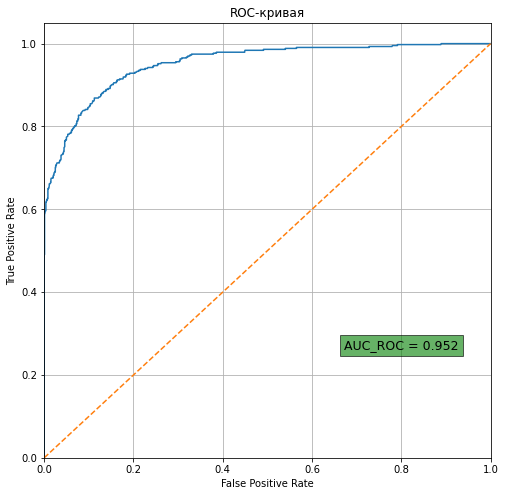

,predicted 0,predicted 1
actual 0,1282,45
actual 1,124,310


In [147]:
# предсказание вероятностей
model_cat.fit(wood_features_train[features_cat],wood_target_train)
probabilities_test = model_cat.predict_proba(wood_features_test[features_cat])
probabilities_one_test = probabilities_test[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
print(probabilities_one_test.shape)
fpr, tpr, thresholds = roc_curve(wood_target_test, probabilities_one_test)
auc_roc = roc_auc_score(wood_target_test, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(wood_target_test, predict_test)

In [148]:
acc = accuracy_score(wood_target_test, predict_test)
f'Accuracy Catboost равно {acc:0.3f}'

'Accuracy Catboost равно 0.904'

#### Результаты

In [149]:
df_results = res_data(df_results, auc_roc, acc, wood_target_test, predict_test, 'Catboost_hyper')
df_results.sort_values(by='auc_roc', ascending=False)

,auc_roc,accuracy,TP,FP
Catboost_hyper,0.952,0.904,310.0,45.0
Случайный лес(f_i),0.929,0.896,251.0,0.0
"Случайный лес(f_i, up)",0.929,0.814,360.0,182.0
CatBoost(f_i),0.928,0.881,270.0,46.0
"CatBoost(f_i, up)",0.927,0.843,374.0,217.0
CatBoost,0.916,0.872,280.0,72.0
CatBoost(up),0.915,0.827,357.0,227.0
Случайный лес,0.860,0.832,246.0,108.0
Дерево решений(up),0.859,0.735,366.0,399.0
Случайный лес(up),0.859,0.814,284.0,177.0


### Вывод 


В результате подбора гиперпараметров AUC_ROC выросла на 0. 024, так TP выросла на 40 единиц при практически неизменном значении FP.